## Imports

In [1]:
import pandas as pd
import numpy as np

# CNN
import keras

# Graph
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from sklearn.model_selection import train_test_split

# AWS
import boto3

Using TensorFlow backend.


## Flow Data Into Keras From Directory

In [2]:
# Alters Imgaes
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Taking data and classes from the data directory
image_gen = image_gen.flow_from_directory(
    "Image-Data",  # Location of data/images
    target_size=(300, 300),  # Image pixels
    color_mode='rgb',  # Color scale
    classes=None,
    class_mode='categorical',
    batch_size=5_000,  # Amount of chosen data
    shuffle=True,
    seed=123,  # Keeps same results
    save_to_dir=None,
    save_prefix='',
    save_format='png',  # File type
    follow_links=False,
    interpolation='nearest')

Found 3913 images belonging to 2 classes.


In [4]:
# Number of classes and what classes there are
image_gen.class_indices

{'Normal': 0, 'Pneumonia': 1}

## Images and Labels

In [5]:
# Separating the images from the labels
images, labels = next(image_gen)
images.shape, labels.shape

((3913, 300, 300, 3), (3913, 2))

## Showing Images

Classes:{'Normal': 0, 'Pneumonia': 1}
[0. 1.]


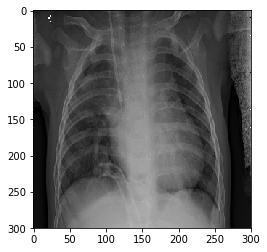

In [6]:
def show_image(n):
    """
    n represents the image number
    you want to see.
    images is a tensor (a bunch of array)
    and entering the number will show you
    which tensor/image you chose.
    The labels are connected to each image,
    choosing the same image number for labels
    will show you the label/class that goes
    with the image.
    """
    
    print(f"Classes:{image_gen.class_indices}")  # Prints the two classes we have along with their indices
    plt.imshow(images[n])  # Shows our chosen image
    print(labels[n])  # Shows which label/class the chosen image is
    
show_image(80)

## Test Split

In [8]:
# Obtaining test data to use as unseen data
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=24)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((3130, 300, 300, 3), (783, 300, 300, 3), (3130, 2), (783, 2))

## Train and Validation Split

In [9]:
# Obtaining training and validation sets to train the neural network
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=24)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2504, 300, 300, 3), (626, 300, 300, 3), (2504, 2), (626, 2))

## Convolutional Neural Network

In [51]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))


# 4rd - convolutional layer
cnn.add(keras.layers.Conv2D(15, (3, 3), 
                            activation='relu', 
                            padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(15, activation='relu'))  # 5th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 6th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

## Callbacks for CNN

In [52]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [53]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [54]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=3,
    verbose=0, mode='auto')

## Content Summary of CNN

In [55]:
print(cnn.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 150, 150, 15)      4335      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 15)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 84375)            

## Loading Saved Model and Weights
- This is a backtrack after the 2nd hyperparameter tuning out performed the initial cnn.
- Coming backtracking to see if we are able to get a better score out of the initial cnn.
- Loading weights in to continue lost progress due to running/tuning other models.

**What Changed?**
- I added another 5 ephocs to make a grand total of 20 epochs.
- I did this because I saw that the 2nd hyperparameter tuning model had a lower loss than the initial model.

In [56]:
cnn.load_weights(weights1)

## Training and Testing The CNN

In [58]:
# Fitting the model to the data to train/learn to predict.
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=20,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 2504 samples, validate on 626 samples
Epoch 1/5
2504/2504 [==============================] - 395s 158ms/step - loss: 0.0759 - acc: 0.9724 - val_loss: 0.1338 - val_acc: 0.9601
Epoch 2/5
2504/2504 [==============================] - 394s 157ms/step - loss: 0.0644 - acc: 0.9764 - val_loss: 0.1311 - val_acc: 0.9537
Epoch 3/5
2504/2504 [==============================] - 394s 157ms/step - loss: 0.0497 - acc: 0.9812 - val_loss: 0.1656 - val_acc: 0.9473
Epoch 4/5
2504/2504 [==============================] - 394s 157ms/step - loss: 0.0495 - acc: 0.9796 - val_loss: 0.1429 - val_acc: 0.9553
Epoch 5/5
2504/2504 [==============================] - 393s 157ms/step - loss: 0.0337 - acc: 0.9860 - val_loss: 0.1710 - val_acc: 0.9473


In [59]:
# Getting the accuracy score using train and test
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

783/783 [==============================] - 27s 35ms/step
[0.01914424126961837, 0.9944089651107788] [0.1458967569192555, 0.9514687061309814]


## Initial CNN Conclusion
- Started off with 6 layers, 4 convolutional and the last 2 are dense.
- The model performed amazingly with a 95% accuracy score

## Saving Model and Weights
- Saving the model saves the architecture/build of the CNN (model).
- Saving the weights saves the parameters/coefficients of the model, which gives us our score/performance

**By doing this, if we decide to close our program or if something were to happen, our progress would still be saved and you wouldn't have to start from the beginning**

In [23]:
# File path names
weights1 = "weights.hdf5"
model1 = "model.hdf5"

In [24]:
cnn.save(filepath=model1, overwrite=True)  # Saving the model
cnn.save_weights(filepath=weights1, overwrite=True)  # Saving the weights of our model

## Hyperparameter Tuning #1

In [25]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(15, activation='relu'))  # 4th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 5th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

## Callbacks for CNN

In [26]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [27]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [28]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=3,
    verbose=0, mode='auto')

## Content Summary of CNN

In [29]:
print(cnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 720000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                10800015  
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

## Training and Testing The CNN

In [ ]:
# Fitting the model to the data to train/learn to predict.
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=20,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 2504 samples, validate on 626 samples
Epoch 1/5
2504/2504 [==============================] - 353s 141ms/step - loss: 0.0677 - acc: 0.9768 - val_loss: 0.1653 - val_acc: 0.9377
Epoch 2/5
2504/2504 [==============================] - 353s 141ms/step - loss: 0.0461 - acc: 0.9836 - val_loss: 0.1540 - val_acc: 0.9409
Epoch 3/5
1340/2504 [===============>..............] - ETA: 2:34 - loss: 0.1060 - acc: 0.9619

In [34]:
# Getting the accuracy score using train and test
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

783/783 [==============================] - 25s 32ms/step
[0.028124475647091342, 0.9884185194969177] [0.17565717554792742, 0.9476373195648193]


## Hyperparameter #1 Conclusion
- Took off a convolutional layer. There are now 3 convolutionals and 2 dense.
- Because a convolutional layer was taken off, there is now a bigger pixel size of the image.
- The number of parameters are higher than the initial CNN.
- The first hyperparameter tuning has actually out performed the second one resources.
- This has an accuracy of 95%, making the initial CNN better.

## Hyperparameter Tuning #2

In [65]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

# 1st - convolutional layer
cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

# 2nd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# 3rd - convolutional layer
cnn.add(keras.layers.Conv2D(32, (3, 3),
                            activation='relu', 
                            padding='SAME'))

# Flatten images
cnn.add(keras.layers.Flatten())

cnn.add(keras.layers.Dense(32, activation='relu'))  # 4th - dense layer
cnn.add(keras.layers.Dense(2, activation='softmax'))  # 5th - dense layer

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

## Callbacks for CNN

In [66]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=3,
    verbose=0, mode='auto', min_lr=0)

In [67]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [68]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=3,
    verbose=0, mode='auto')

## Content Summary of CNN

In [69]:
print(cnn.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
flatten_7 (Flatten)          (None, 720000)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                23040032  
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

## Training and Testing The CNN

In [71]:
# Fitting the model to the data to train/learn to predict.
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=15,
               batch_size=10,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 2504 samples, validate on 626 samples
Epoch 1/5
2504/2504 [==============================] - 368s 147ms/step - loss: 0.0535 - acc: 0.9820 - val_loss: 0.1560 - val_acc: 0.9521
Epoch 2/5
2504/2504 [==============================] - 368s 147ms/step - loss: 0.0354 - acc: 0.9864 - val_loss: 0.2068 - val_acc: 0.9361
Epoch 3/5
2504/2504 [==============================] - 369s 147ms/step - loss: 0.0184 - acc: 0.9940 - val_loss: 0.1883 - val_acc: 0.9281
Epoch 4/5
2504/2504 [==============================] - 369s 147ms/step - loss: 0.0110 - acc: 0.9960 - val_loss: 0.1655 - val_acc: 0.9441
Epoch 5/5
2504/2504 [==============================] - 369s 147ms/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.1746 - val_acc: 0.9489


In [76]:
# Getting the accuracy score using train and test
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

783/783 [==============================] - 26s 33ms/step
[0.040320902378462, 0.9832268357276917] [0.11605958033491064, 0.961685836315155]


## Hyperparameter #2 Conclusion
- On the 4th dense layer, more nodes were given to match the 3rd convolutional layer, 32 nodes.
- The second hyperparameter tuning did better than the initial (first model) and the other hyperparameter tuning model (Hyperparameter Tuning #1)
- The accuracy measures at 96%

## Saving Hyperparameter Tuning #2's Model and Weights

In [77]:
# File path names
model_tune2 = "model_tune2.hdf5"
weights_tune2 = "weights_tune2.hdf5"

In [78]:
cnn.save(model_tune2, overwrite=True)
cnn.save_weights(weights_tune2, overwrite=True)

# Full Conclusion
- The second hyperparameter tuning out did all of the other models with a 96% accuracy score
- Hyperparameter Tuning #2 was different from the rest by having only 5 layers, 3 convolutional and 2 dense layers. The 1st dense layer was differernt because the nodes were changed to 32 nodes to match the 3rd convolutional layer.
- Overall, our model is able to predict cases of Pneumonia in Chest X-ray images with 96% accuracy